In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
print("All libraries loaded!")

All libraries loaded!


In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Shape: (7043, 21)

First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Fix TotalCharges column (it has spaces, should be numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values (only ~11 rows)
df.dropna(inplace=True)

# Drop customerID (not useful for analysis)
df.drop(columns=['customerID'], inplace=True)

# Convert Churn to 0/1
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("Cleaned! Shape:", df.shape)
print("\nMissing values:", df.isnull().sum().sum())

Cleaned! Shape: (7032, 20)

Missing values: 0


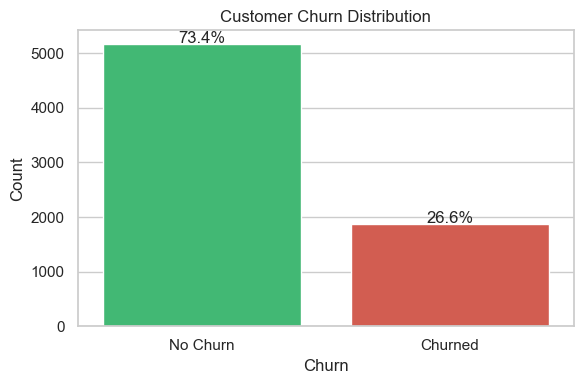

In [4]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Churn', data=df, palette=['#2ecc71','#e74c3c'])
ax.set_xticklabels(['No Churn', 'Churned'])
plt.title('Customer Churn Distribution')
plt.ylabel('Count')

# Add percentage labels
total = len(df)
for p in ax.patches:
    pct = f"{100 * p.get_height() / total:.1f}%"
    ax.annotate(pct, (p.get_x() + p.get_width()/2, p.get_height() + 30), ha='center')

plt.tight_layout()
plt.savefig('churn_distribution.png', dpi=150)
plt.show()

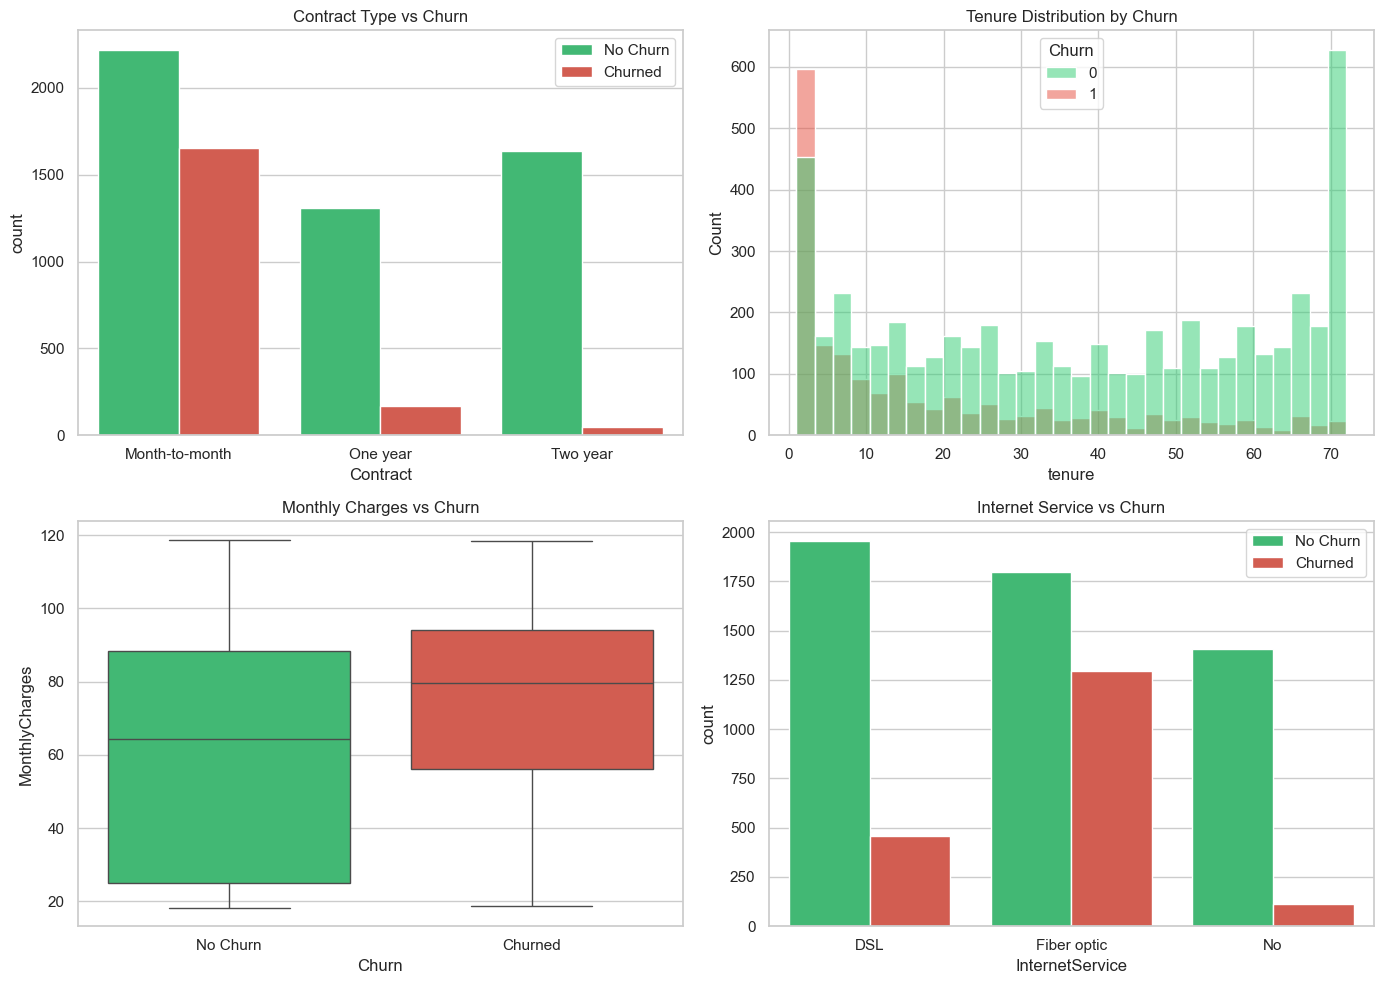

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Contract Type vs Churn
sns.countplot(x='Contract', hue='Churn', data=df, palette=['#2ecc71','#e74c3c'], ax=axes[0,0])
axes[0,0].set_title('Contract Type vs Churn')
axes[0,0].legend(['No Churn', 'Churned'])

# 2. Tenure vs Churn
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, palette=['#2ecc71','#e74c3c'], ax=axes[0,1])
axes[0,1].set_title('Tenure Distribution by Churn')

# 3. Monthly Charges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette=['#2ecc71','#e74c3c'], ax=axes[1,0])
axes[1,0].set_xticklabels(['No Churn', 'Churned'])
axes[1,0].set_title('Monthly Charges vs Churn')

# 4. Internet Service vs Churn
sns.countplot(x='InternetService', hue='Churn', data=df, palette=['#2ecc71','#e74c3c'], ax=axes[1,1])
axes[1,1].set_title('Internet Service vs Churn')
axes[1,1].legend(['No Churn', 'Churned'])

plt.tight_layout()
plt.savefig('eda_key_factors.png', dpi=150)
plt.show()

In [6]:
# Encode all categorical columns
df_model = df.copy()
le = LabelEncoder()
cat_cols = df_model.select_dtypes(include='object').columns

for col in cat_cols:
    df_model[col] = le.fit_transform(df_model[col])

# Split features and target
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("=== Model Performance ===")
print(classification_report(y_test, y_pred, target_names=['No Churn','Churned']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.3f}")

=== Model Performance ===
              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86      1033
     Churned       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC Score: 0.813


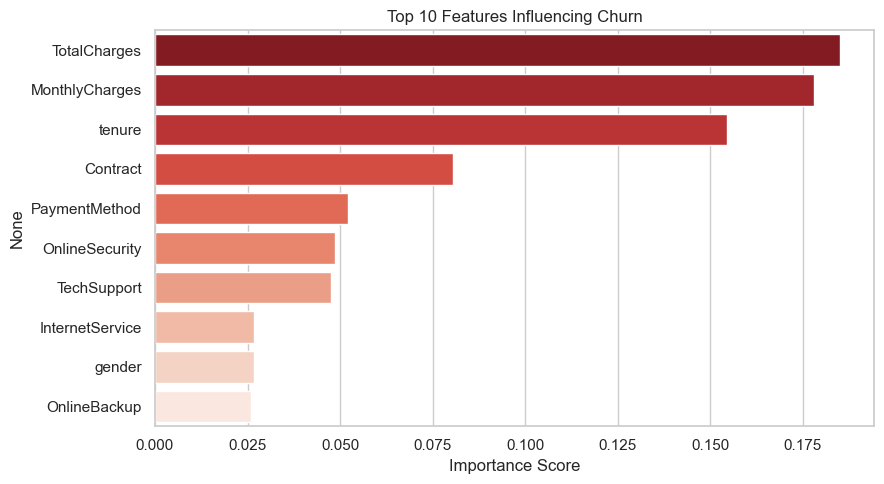

In [7]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(9,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='Reds_r')
plt.title('Top 10 Features Influencing Churn')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

In [8]:
# Export the cleaned dataset
df.to_csv('churn_clean.csv', index=False)

# Export model predictions on test set for Power BI
X_test_copy = X_test.copy()
X_test_copy['Actual_Churn'] = y_test.values
X_test_copy['Predicted_Churn'] = y_pred
X_test_copy['Churn_Probability'] = model.predict_proba(X_test)[:,1].round(3)
X_test_copy.to_csv('churn_predictions.csv', index=False)

print("✅ Files saved: churn_clean.csv and churn_predictions.csv")

✅ Files saved: churn_clean.csv and churn_predictions.csv
